# Protein Secondary Structure Prediction Example

This notebook demonstrates the complete workflow for protein secondary structure prediction using our LSTM model. It covers:
1. Data preprocessing and vocabulary creation
2. Model training and evaluation
3. Visualization of results
4. Making predictions on new sequences

## 1. Setup and Imports

In [1]:
# Import necessary libraries
import sys
sys.path.append('../scripts')  # Add scripts directory to path

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Import our custom modules
from protein_struct_preprocess import preprocess_proteins
from protein_struct_model_prep import proteinDataset, pad_mask
from protein_struct_model import lstm_model, protein_train, evaluate
from protein_plots import evaluate_with_visualizations

# Set up device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

2025-11-09 23:38:55,975 | INFO | Using Apple mps


Using device: mps


## 2. Data Loading and Preprocessing

In [2]:
# Define file paths
train_df = "../dataset/training_secondary_structure_train.csv"
val_df = "../dataset/validation_secondary_structure_valid.csv"
test_df = "../dataset/test_secondary_structure_casp12.csv"

# Preprocess training data to create vocabularies
print("Preprocessing training data...")
t_data, t_prime2idx, t_lab3, t_lab8 = preprocess_proteins(train_df)

# Load validation and test data
v_data = pd.read_csv(val_df)
ts_data = pd.read_csv(test_df)

print(f"Training data shape: {t_data.shape}")
print(f"Validation data shape: {v_data.shape}")
print(f"Test data shape: {ts_data.shape}")
print(f"Amino acid vocabulary size: {len(t_prime2idx)}")
print(f"3-class labels: {t_lab3}")
print(f"8-class labels: {t_lab8}")

Preprocessing training data...
Training data shape: (8678, 3)
Validation data shape: (2170, 3)
Test data shape: (21, 3)
Amino acid vocabulary size: 23
3-class labels: {'<PAD>': 0, 'C': 1, 'E': 2, 'H': 3}
8-class labels: {'<PAD>': 0, 'B': 1, 'C': 2, 'E': 3, 'G': 4, 'H': 5, 'I': 6, 'S': 7, 'T': 8}


## 3. Data Exploration

Sample training data:
                                                 seq  \
0  AETVESCLAKSHTENSFTNVXKDDKTLDRYANYEGCLWNATGVVVC...   
1  ASQEISKSIYTCNDNQVXEVIYVNTEAGNAYAIISQVNEXIPXRLX...   
2  XGSSHHHHHHSSGRENLYFQGXNISEINGFEVTGFVVRTTNADEXN...   
3  SNADYNRLSVPGNVIGKGGNAVVYEDAEDATKVLKMFTTSQSNEEV...   
4  DTVGRPLPHLAAAMQASGEAVYCDDIPRYENELFLRLVTSTRAHAK...   

                                                sst3  \
0  CCCHHHHHCCCCEEEEEECCEECCCCCCEEEEECCEEEEEEEEEEE...   
1  CCCCEEEEEEEECCCEEEEEEEEECCCCCEEEEEEECCEEEEEEEE...   
2  CCCCCCCCCCCCCCCCCEEEEEEEEEECCEEEEEEEEEECHHHHHC...   
3  CCCCCCCCCCEEEEEEECCCEEEEEECCCCCEEEEEECCCCCHHHH...   
4  CCCCCCCCCCCHHHHHCCCCCCHHHCCCCCCCEEEEEEECCCCCEE...   

                                                sst8  
0  CCCHHHHHTSCCEEEEEESCEECTTTCCEEEEETTEEEEEEEEEEE...  
1  CCCCEEEEEEEETTTEEEEEEEEECTTSCEEEEEEETTEEEEEEEE...  
2  CCCCCCCCCCCCCCCCCEEEEEEEEEECCEEEEEEEEEECHHHHHS...  
3  CCCCCCCCCCEEEEEEECSSEEEEEETTCTTEEEEEESSCCCHHHH...  
4  CCTTSCCCCTTHHHHHTTCSCCGGGS

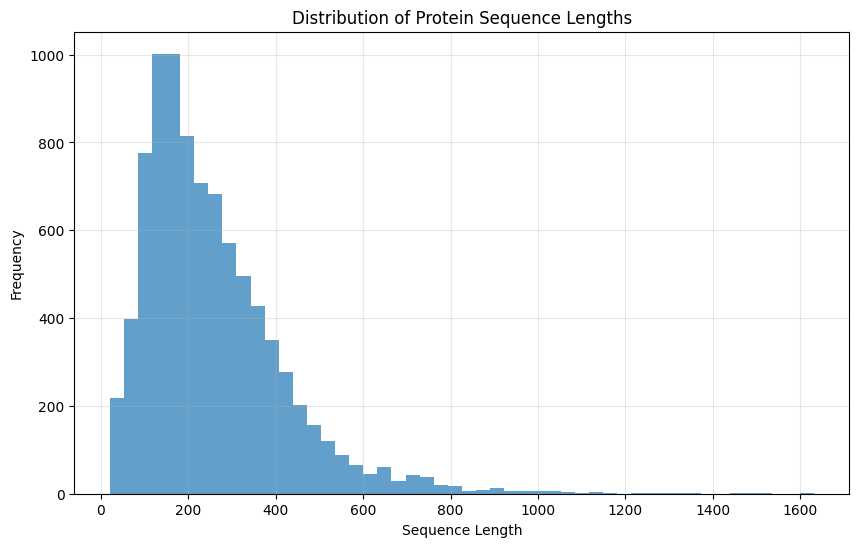

In [3]:
# Display sample data
print("Sample training data:")
print(t_data.head())

# Analyze sequence length distribution
seq_lengths = t_data['seq'].str.len()
print(f"\nSequence length statistics:")
print(f"Mean: {seq_lengths.mean():.2f}")
print(f"Median: {seq_lengths.median():.2f}")
print(f"Min: {seq_lengths.min()}")
print(f"Max: {seq_lengths.max()}")

# Plot sequence length distribution
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50, alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Protein Sequence Lengths')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Dataset and DataLoader Setup

In [ ]:
# Setup collate function for padding and masking
collate = lambda batch: pad_mask(batch, x_pad=t_prime2idx, y_pad=t_lab3)

# Create datasets
train_dataset = proteinDataset(
    data=t_data, 
    prime2idx=t_prime2idx, 
    lab3=t_lab3, 
    lab8=t_lab8, 
    label_mode="q8",  # Use 8-class prediction
    max_len=512
)

val_dataset = proteinDataset(
    data=v_data, 
    prime2idx=t_prime2idx, 
    lab3=t_lab3, 
    lab8=t_lab8, 
    label_mode='q8', 
    max_len=512
)

test_dataset = proteinDataset(
    data=ts_data, 
    prime2idx=t_prime2idx, 
    lab3=t_lab3, 
    lab8=t_lab8, 
    label_mode='q8', 
    max_len=512
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=collate, 
    num_workers=0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    collate_fn=collate, 
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=False, 
    collate_fn=collate, 
    num_workers=0
)

print(f"Created datasets and data loaders")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

## 5. Model Initialization

In [ ]:
# Initialize the LSTM model
model = lstm_model(
    vocab_size=t_prime2idx, 
    num_tags=len(t_lab8),  # Number of output classes
    pad_id=t_prime2idx["<PAD>"],
    hidden=20,  # Hidden dimension
    embed_dim=20,  # Embedding dimension
    bidir=True  # Use bidirectional LSTM
)

model = model.to(device)
print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

## 6. Model Training

In [ ]:
# Train the model
print("Starting model training...")
trained_model, best_model_state = protein_train(
    lab3=t_lab8,  # Use 8-class labels
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    n_factors=30, 
    n_epochs=20, 
    batch_size=512, 
    label_mode='q8', 
    device=device
)

print("Training completed!")

## 7. Model Evaluation

In [ ]:
# Evaluate the trained model on test data
print("Evaluating model on test data...")
evaluate(
    lab3=t_lab8, 
    test_loader=test_loader, 
    model=trained_model, 
    batch_size=512, 
    device=device
)

## 8. Generate Comprehensive Visualizations

In [ ]:
# Generate visualizations using the trained model
print("Generating comprehensive visualizations...")
evaluate_with_visualizations(
    model_path="best_model_state_for_label8.pth", 
    test_data_path=test_df, 
    prime2idx=t_prime2idx, 
    lab3=t_lab8, 
    device=device
)

print("All visualizations completed!")

## 9. Making Predictions on New Sequences

In [ ]:
def predict_structure(sequence, model, prime2idx, lab3, device="mps"):
    """
    Predict secondary structure for a new protein sequence.
    
    Args:
        sequence (str): Amino acid sequence
        model: Trained model
        prime2idx (dict): Amino acid to index mapping
        lab3 (dict): Label to index mapping
        device (str): Device to use
        
    Returns:
        tuple: (predicted_labels, confidence_scores)
    """
    # Convert sequence to indices
    seq_indices = [prime2idx.get(aa.upper(), prime2idx["<UNK>"]) for aa in sequence]
    
    # Convert to tensor and add batch dimension
    seq_tensor = torch.tensor([seq_indices], dtype=torch.long).to(device)
    
    # Create mask (all 1s since no padding)
    mask = torch.ones_like(seq_tensor, dtype=torch.bool)
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Get model predictions
        logits = model(seq_tensor)
        
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)
        
        # Get predicted labels and confidence scores
        pred_indices = logits.argmax(-1)[0]
        confidence_scores = probs.max(-1)[0]
        
        # Convert indices to labels
        idx2label = {v: k for k, v in lab3.items()}
        pred_labels = [idx2label[idx.item()] for idx in pred_indices]
        
        return pred_labels, confidence_scores.cpu().numpy()

# Example usage with a sample sequence
sample_sequence = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids
predicted_labels, confidence_scores = predict_structure(
    sequence=sample_sequence,
    model=trained_model,
    prime2idx=t_prime2idx,
    lab3=t_lab8,
    device=device
)

print(f"Sequence: {sample_sequence}")
print(f"Predicted structure: {''.join(predicted_labels)}")
print(f"Average confidence: {np.mean(confidence_scores):.3f}")

# Visualize the prediction
plt.figure(figsize=(12, 4))
structure_colors = {'H': 'red', 'E': 'yellow', 'C': 'grey', 'G': 'blue', 'I': 'green', 
                   'B': 'orange', 'T': 'purple', 'S': 'pink'}
colors = [structure_colors.get(label, 'black') for label in predicted_labels]
plt.bar(range(len(predicted_labels)), [1]*len(predicted_labels), color=colors)
plt.xticks(range(len(sample_sequence)), list(sample_sequence))
plt.xlabel('Amino Acid Position')
plt.ylabel('Structure')
plt.title('Predicted Secondary Structure')
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=0.3)
plt.show()

## 10. Model Comparison (Optional)

In [ ]:
# Compare different model configurations
def compare_models(hidden_dims, embed_dims):
    """
    Compare models with different hyperparameters.
    
    Args:
        hidden_dims (list): List of hidden dimensions to test
        embed_dims (list): List of embedding dimensions to test
        
    Returns:
        pd.DataFrame: Comparison results
    """
    results = []
    
    for hidden in hidden_dims:
        for embed in embed_dims:
            print(f"\nTraining model with hidden={hidden}, embed={embed}...")
            
            # Create model
            test_model = lstm_model(
                vocab_size=t_prime2idx,
                num_tags=len(t_lab8),
                pad_id=t_prime2idx["<PAD>"],
                hidden=hidden,
                embed_dim=embed,
                bidir=True
            )
            
            # Train for fewer epochs for comparison
            _, _ = protein_train(
                lab3=t_lab8,
                model=test_model,
                train_loader=train_loader,
                val_loader=val_loader,
                n_epochs=5,  # Fewer epochs for quick comparison
                batch_size=256,
                label_mode='q8',
                device=device
            )
            
            # Evaluate on validation set
            test_model.eval()
            all_p, all_y = [], []
            
            with torch.no_grad():
                for x, y, mask in val_loader:
                    x, y, mask = x.to(device), y.to(device), mask.to(device)
                    
                    logits = test_model(x)
                    prob = logits.argmax(-1)
                    
                    for yi, pi, mi in zip(y, prob, mask):
                        yi = yi[mi].tolist()
                        pi = pi[mi].tolist()
                        all_y.append(yi)
                        all_p.append(pi)
            
            # Calculate accuracy
            idx2tag = {v: k for k, v in t_lab8.items()}
            true_tags = [idx2tag[tag] for sequence in all_y for tag in sequence]
            predict_tags = [idx2tag[tag] for sequence in all_p for tag in sequence]
            
            accuracy = sum(1 for t, p in zip(true_tags, predict_tags) if t == p) / len(true_tags)
            
            results.append({
                'Hidden Dim': hidden,
                'Embed Dim': embed,
                'Accuracy': accuracy,
                'Parameters': sum(p.numel() for p in test_model.parameters())
            })
    
    return pd.DataFrame(results)

# Run comparison (commented out to save time)
# comparison_results = compare_models([10, 20], [10, 20])
# print(comparison_results)

# Plot comparison results
# plt.figure(figsize=(10, 6))
# for embed_dim in [10, 20]:
#     subset = comparison_results[comparison_results['Embed Dim'] == embed_dim]
#     plt.plot(subset['Hidden Dim'], subset['Accuracy'], 'o-', label=f'Embed={embed_dim}')
# 
# plt.xlabel('Hidden Dimension')
# plt.ylabel('Validation Accuracy')
# plt.title('Model Performance vs. Architecture')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

## 11. Summary and Next Steps

This notebook demonstrated the complete workflow for protein secondary structure prediction:

1. **Data Preprocessing**: Created vocabularies for amino acids and structure labels
2. **Model Training**: Trained a bidirectional LSTM with early stopping
3. **Evaluation**: Assessed model performance on test data
4. **Visualization**: Generated comprehensive visualizations of model behavior
5. **Prediction**: Made predictions on new sequences

### Potential Improvements:
- Try different architectures (Transformers, CNNs)
- Implement hyperparameter tuning
- Use pre-trained protein embeddings
- Add attention mechanisms
- Experiment with different loss functions

### Applications:
- Protein function prediction
- Drug target identification
- Protein engineering
- Structure validation